In [1]:
import numpy as np
import pickle

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from plots import knn_classifier_plot
from matplotlib.colors import ListedColormap
import seaborn as sns
from plots import plot_classifier
from sklearn import datasets

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

### Neural Network Classifier

In [3]:
class NNClassifier:
    """Multiclass neural network classifier"""
    def __init__(self, hidden_layers=None, learning_rate=0.001, max_iter=1000):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate * 1000
        self.max_iter = max_iter
        self.W_list = None
        self.b_list = None
        self.a_list = None
        self.z_list = None
        self.J_W_list = None
        self.J_b_list = None
        # conversion of labels
        self.names = None
        self.labels = None
        self.name_to_label = None
        self.label_to_name = None
        self.y_shape = None
        
    def fit(self, X, y):
        """train neural network
        
        Parameters
        ----------
        X: input dataset
            (n_samples, n_features)
        y: output data
            (n_samples) or (n_samples, x)"""
        self.X = X.T
        self.size = X.size
        self.y_shape = y.shape
        
        if y.ndim == 1:
            self.y = y.reshape(-1, 1)
            self.y = self.update_y(self.y)
        elif y.shape[1] == 1:
            self.y = self.update_y(y)
        else:
            self.y = y.T
            
        if self.hidden_layers:
            self.layers = [self.X.shape[0]] + list(self.hidden_layers) + [self.y.shape[0]]
        else:
            self.layers = [self.X.shape[0], self.y.shape[0]]
        
        self.costs = []
        self.initialize_variables()
        self.initialize_weights()
        
        for i in range(self.max_iter):
            self.feed_forward(self.X)
            self.back_prop(self.y)
            
            if i % 10 == 0:
                self.costs.append(self.calculate_cost(self.y))
        
        return self
    
    def load(self, filename):
        """load model from a pickle file"""
        file = filename
        if not file.endswith(".pickle"):
            file += ".pickle"
        with open(file, "rb") as f:
            clf = pickle.load(f)
        return clf
    
    def save(self, filename):
        """save model into a pickle file"""
        file = filename
        if not file.endswith(".pickle"):
            file += ".pickle"
        with open(file, "wb") as f:
            pickle.dump(self, f)
        
    def update_y(self, y):
        # create label and name lists and dicts
        # names: outputs in raw y (["dog", "cat", ...])
        # labels: new labels of outputs ([0, 1, ...])
        self.names = list(np.unique(y))
        self.labels = [i for i in range(len(self.names))]
        self.name_to_label = dict(zip(self.names, self.labels))
        self.label_to_name = dict(zip(self.labels, self.names))
        # update output array as a boolean array
        output = np.zeros((len(self.labels), y.shape[0]))
        for i, n in enumerate(y):
            output[self.name_to_label[n[0]], i] = 1
        
        return output
    
    def initialize_variables(self):
        self.a_list = [None] * len(self.layers)
        self.z_list = [None] * len(self.layers)
        self.J_W_list = [None] * (len(self.layers) - 1)
        self.J_b_list = [None] * (len(self.layers) - 1)
    
    def initialize_weights(self):
        self.W_list = [None] * (len(self.layers) - 1)
        self.b_list = [None] * (len(self.layers) - 1)
        for i in range(len(self.W_list)):
            self.W_list[i] = np.random.randn(self.layers[i+1], self.layers[i])
            self.b_list[i] = np.random.randn(self.layers[i+1], 1)
    
    def feed_forward(self, inputs):
        """feed forward and compute predicted outputs"""
        self.a_list[0] = inputs
        for i in range(1, len(self.layers) - 1):
            self.z_list[i] = self.W_list[i-1] @ self.a_list[i-1] + self.b_list[i-1]
            self.a_list[i] = self.activation(self.z_list[i])
        self.z_list[-1] = self.W_list[-1] @ self.a_list[-2] + self.b_list[-1]
        self.a_list[-1] = self.softmax(self.z_list[-1])
            
    def back_prop(self, y):
        """backpropogate and update weights and biases"""
        J_raw = 2 * (self.a_list[-1] - y)
        #J_raw = J_raw * self.d_activation(self.z_list[-1])
        for i in range(len(self.W_list) - 1, -1, -1):
            J = J_raw
            for j in range(len(self.W_list) - 1, i, -1):
                J = (J.T @ self.W_list[j]).T
                J = J * self.d_activation(self.z_list[j])
                
            # J for weights
            J_W = J @ self.a_list[i].T / self.size
            self.J_W_list[i] = J_W
            # J for biases
            J_b = np.sum(J, axis=1, keepdims=True) / self.size
            self.J_b_list[i] = J_b
        
        # update weights and biases
        for i in range(len(self.W_list) - 1, -1, -1):
            self.W_list[i] -= self.learning_rate * self.J_W_list[i]
            self.b_list[i] -= self.learning_rate * self.J_b_list[i]
    
    def predict(self, X):
        """predicts output"""
        self.feed_forward(X.T)
        if self.labels is None:
            return self.a_list[-1].T
        
        # arg of maximums by argmax
        max_args = np.argmax(self.a_list[-1], axis=0).T
        # update predictions according to labels
        y_pred = list(map(lambda x: self.label_to_name[x], max_args))
        y_pred = np.array(y_pred)
        
        return y_pred
    
    def predict_proba(self, X):
        """predict probabilities of each class"""
        self.feed_forward(X.T)
        output = self.a_list[-1].T
        
        return output

    def score(self, X, y):
        y_pred = self.predict(X).reshape(y.shape)
        
        return (y_pred == y).sum() / len(y)
    
    def calculate_cost(self, y):
        #return np.linalg.norm(self.a_list[-1] - self.y)**2 / self.size
        return np.sum(-y * np.log(self.a_list[-1]))
    
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
    
    def d_activation(self, z):
        return np.cosh(z/2)**(-2) / 4
    
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / exp_z.sum(axis=0)

In [5]:
class NNCoursera:
    """Binary neural network classifier"""
    def __init__(self, hidden_layers=None, learning_rate=0.001, max_iter=1000):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate * 1000
        self.max_iter = max_iter
        self.W_list = None
        self.b_list = None
        self.a_list = None
        self.z_list = None
        self.J_W_list = None
        self.J_b_list = None
        self.is_y_transposed = False
        
    def fit(self, X, y):
        self.X = X.T
        if y.ndim == 1:
            self.y = y.reshape(1, -1)
        else:
            self.y = y.T
            self.is_y_transposed = True
        self.size = X.size
            
        if self.hidden_layers:
            self.layers = [self.X.shape[0]] + list(self.hidden_layers) + [self.y.shape[0]]
        else:
            self.layers = [self.X.shape[0], self.y.shape[0]]
        
        self.costs = []
        self.initialize_weights()
        
        for i in range(self.max_iter):
            self.feed_forward(self.X)
            self.back_prop(self.y)
            
            if i % 10 == 0:
                self.costs.append(self.calculate_cost())
        
        return self
    
    def initialize_weights(self):
        self.a_list = [None] * len(self.layers)
        self.z_list = [None] * len(self.layers)
        self.J_W_list = [None] * (len(self.layers) - 1)
        self.J_b_list = [None] * (len(self.layers) - 1)
        
        self.W_list = [None] * (len(self.layers) - 1)
        self.b_list = [None] * (len(self.layers) - 1)
        for i in range(len(self.W_list)):
            self.W_list[i] = np.random.randn(self.layers[i+1], self.layers[i])
            self.b_list[i] = np.random.randn(self.layers[i+1], 1)
    
    def feed_forward(self, inputs):
        self.a_list[0] = inputs
        for i in range(1, len(self.layers)):
            self.z_list[i] = self.W_list[i-1] @ self.a_list[i-1] + self.b_list[i-1]
            self.a_list[i] = self.activation(self.z_list[i])
            
    def back_prop(self, y):
        J_raw = 2 * (self.a_list[-1] - y)
        J_raw = J_raw * self.d_activation(self.z_list[-1])
        for i in range(len(self.W_list) - 1, -1, -1):
            J = J_raw
            for j in range(len(self.W_list) - 1, i, -1):
                J = (J.T @ self.W_list[j]).T
                J = J * self.d_activation(self.z_list[j])
                
            # J for weights
            J_W = J @ self.a_list[i].T / self.size
            self.J_W_list[i] = J_W
            # J for biases
            J_b = np.sum(J, axis=1, keepdims=True) / self.size
            self.J_b_list[i] = J_b
        
        # update weights and biases
        for i in range(len(self.W_list) - 1, -1, -1):
            self.W_list[i] -= self.learning_rate * self.J_W_list[i]
            self.b_list[i] -= self.learning_rate * self.J_b_list[i]
    
    def predict(self, X):
        output = self.predict_proba(X)
        y_preds = np.where(output < 0.5, 0, 1)
        
        return y_preds
    
    def predict_proba(self, X):
        self.feed_forward(X.T)
        
        if self.is_y_transposed:
            output = self.a_list[-1].T
        else:
            output = self.a_list[-1][0]
        
        return output

    def score(self, X, y):
        y_pred = self.predict(X)
        
        return (y_pred == y).sum() / len(y)
    
    def calculate_cost(self):
        return np.linalg.norm(self.a_list[-1] - self.y)**2 / self.size
    
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
    
    def d_activation(self, z):
        return np.cosh(z/2)**(-2) / 4

In [16]:
class NNClassifier2:
    def __init__(self, hidden_layers=None, learning_rate=0.001, max_iter=500, tol=0.00001):
        """Neural network classifier model"""
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.hidden_layers = hidden_layers
        self.W_list = []
        self.b_list = []
        self.a_list = []
        self.z_list = []
        self.J_W_list = []
        self.J_b_list = []
        self.names = None
        self.labels = None
        self.name_to_label = None
        self.label_to_name = None
    
    def fit(self, X, y):
        """Train neural network model"""
        self.X = X.copy()
        if y.ndim == 1:
            self.y = y.reshape(-1, 1)
            self.y = self.update_y(self.y)
        elif y.shape[1] == 1:
            self.y = self.update_y(y)
        else:
            self.y = y.copy()
        
        if self.hidden_layers:
            self.layers = [self.X.shape[1]] + list(self.hidden_layers) + [self.y.shape[1]]
        else:
            self.layers = [self.X.shape[1], self.y.shape[1]]
        self.costs = []
        prev_cost = float("inf")
        
        self.initialize_weights()
        for i in range(self.max_iter):
            # feed forward and backpropagate
            self.feed_forward(self.X)
            self.back_prop()
            
            # cost
            cost = self.calculate_cost(self.a_list[-1], self.y)
            self.costs.append(cost)
            
            if abs(prev_cost - cost) < self.tol * prev_cost:
                break
            prev_cost = cost
        
        return self
    
    def update_y(self, y):
        # create label and name lists and dicts
        # names: outputs in raw y (["dog", "cat", ...])
        # labels: new labels of outputs ([0, 1, ...])
        self.names = list(np.unique(y))
        self.labels = [i for i in range(len(self.names))]
        self.name_to_label = dict(zip(self.names, self.labels))
        self.label_to_name = dict(zip(self.labels, self.names))
        # update output array as a boolean array
        output = np.zeros((y.shape[0], len(self.labels)))
        for i, n in enumerate(y):
            output[i, self.name_to_label[n[0]]] = 1
        
        return output
        
    def predict(self, X):
        """predicts output"""
        self.feed_forward(X)
        if self.labels is None:
            return self.a_list[-1]
        
        # arg of maximums by argmax
        max_args = np.argmax(self.a_list[-1], axis=1)
        # update predictions according to labels
        y_pred = list(map(lambda x: self.label_to_name[x], max_args))
        
        return np.array(y_pred).reshape(-1, 1)
    
    def predict_proba(self, X):
        """predicts and returns probabilities"""
        self.feed_forward(X)
        
        return self.a_list[-1]
    
    def initialize_weights(self):
        """initialize weights and biases with random numbers"""
        self.W_list = [None] * (len(self.layers) - 1)
        self.b_list = [None] * (len(self.layers) - 1)
        for i in range(len(self.W_list)):
            self.W_list[i] = np.random.rand(self.layers[i], self.layers[i+1])
            self.b_list[i] = np.random.rand(self.layers[i+1])
    
    def feed_forward(self, input_layer):
        self.a_list = [None] * len(self.layers)
        self.z_list = [None] * len(self.layers)
        self.a_list[0] = input_layer
        for i in range(1, len(self.a_list)):
            z = self.a_list[i-1] @ self.W_list[i-1] + self.b_list[i-1]
            a = self.activation(z)
            self.z_list[i] = z
            self.a_list[i] = a
    
    def back_prop(self):
        self.J_W_list = [None] * len(self.W_list)
        self.J_b_list = [None] * len(self.W_list)
        # reverse iterating for J matrices
        J_raw = 2 * (self.a_list[-1] - self.y)
        J_raw = J_raw * self.d_activation(self.z_list[-1])
        for i in range(len(self.W_list) - 1, -1, -1):
            J = J_raw
            # reverse iteration to calculate J with intervalue
            for j in range(len(self.W_list) - 1, i, -1):
                J *= self.d_activation(self.a_list[j+1])
                J = J @ self.W_list[j].T
            # only for J of Weights
            self.J_W_list[i] = self.a_list[i].T @ J
            # only for J of biases
            self.J_b_list[i] = J.sum(axis=0) / J.shape[0]
        
        # update weights by Jacobians
        for i in range(len(self.W_list) - 1, -1, -1):
            self.W_list[i] -= self.learning_rate * self.J_W_list[i]
            self.b_list[i] -= self.learning_rate * self.J_b_list[i]
            
    def calculate_cost(self, preds, y):
        return ((preds - y) ** 2).sum() / y.shape[0]
    
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
    
    def d_activation(self, z):
        #return 1 / (4 * (np.cosh(z / 2) ** 2))
        return self.activation(z) * (1 - self.activation(z))
    
    def score(self, X, y):
        """compare equality of predictions and true outputs"""
        if y.ndim == 1:
            y_test = y
        elif y.shape[1] == 1:
            y_test = y.ravel()
            
        y_pred = self.predict(X).ravel()
        
        return (y_pred == y_test).sum() / y_pred.shape[0]
    
    def proba_score(self, X, y):
        """R^2 score
        1 - u/v"""
        if y.ndim == 1:
            y_test = y.reshape(-1, 1)
            y_test = self.update_y(y_test)
        elif y.shape[1] == 1:
            y_test = self.update_y(y)
        else:
            y_test = y.copy()
            
        y_pred = self.predict_proba(X)
        u = ((y_test - y_pred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        
        return 1 - u / v
    
    def get_values(self):
        return self.W_list, self.b_list, self.a_list, self.z_list, self.J_W_list, self.J_b_list

In [5]:
class NNTest:
    def __init__(self, hidden_layers=None, learning_rate=0.001, max_iter=500, tol=0.00001):
        """Neural network"""
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.hidden_layers = hidden_layers
        self.W_list = []
        self.b_list = []
        self.a_list = []
        self.z_list = []
        self.J_W_list = []
        self.J_b_list = []
    
    def fit(self, X, y):
        """Train neural network model"""
        self.X = X.copy()
        if y.ndim == 1:
            self.y = y.reshape(-1, 1)
        else:
            self.y = y.copy()
        
        if self.hidden_layers:
            self.layers = [self.X.shape[1]] + list(self.hidden_layers) + [self.y.shape[1]]
        else:
            self.layers = [self.X.shape[1], self.y.shape[1]]
        self.costs = []
        prev_cost = float("inf")
        
        self.initialize_weights()
        for i in range(self.max_iter):
            # feed forward and backpropagate
            self.feed_forward(self.X)
            self.back_prop()
            
            # cost
            cost = self.calculate_cost(self.a_list[-1], self.y)
            self.costs.append(cost)
            
            if abs(prev_cost - cost) < self.tol * prev_cost:
                break
            prev_cost = cost
        
        return self
        
    def predict(self, X):
        self.feed_forward(X)
        
        return self.a_list[-1]
    
    def initialize_weights(self):
        """initialize weights and biases with random numbers"""
        self.W_list = [None] * (len(self.layers) - 1)
        self.b_list = [None] * (len(self.layers) - 1)
        for i in range(len(self.W_list)):
            self.W_list[i] = np.random.rand(self.layers[i], self.layers[i+1])
            self.b_list[i] = np.random.rand(self.layers[i+1])
    
    def feed_forward(self, input_layer):
        self.a_list = [None] * len(self.layers)
        self.z_list = [None] * len(self.layers)
        self.a_list[0] = input_layer
        for i in range(1, len(self.a_list)):
            z = self.a_list[i-1] @ self.W_list[i-1] + self.b_list[i-1]
            a = self.activation(z)
            self.z_list[i] = z
            self.a_list[i] = a
    
    def back_prop(self):
        self.J_W_list = [None] * len(self.W_list)
        self.J_b_list = [None] * len(self.W_list)
        # reverse iterating for J matrices
        for i in range(len(self.W_list) - 1, -1, -1):
            J = 2 * (self.a_list[-1] - self.y)
            # reverse iteration to calculate J with intervalue
            for j in range(len(self.W_list) - 1, i, -1):
                J *= self.d_activation(self.a_list[j+1])
                J = J @ self.W_list[j].T
            J *= self.d_activation(self.a_list[i+1])
            # only for J of Weights
            self.J_W_list[i] = self.a_list[i].T @ J
            # only for J of biases
            self.J_b_list[i] = J.sum(axis=0) / J.shape[0]
        
        # update weights by Jacobians
        for i in range(len(self.W_list) - 1, -1, -1):
            self.W_list[i] -= self.learning_rate * self.J_W_list[i]
            self.b_list[i] -= self.learning_rate * self.J_b_list[i]
            
    def calculate_cost(self, preds, y):
        return ((preds - y) ** 2).sum() / y.shape[0]
    
    def activation(self, z):
        return 1 / (1 + np.exp(-z))
    
    def d_activation(self, z):
        return 1 / (4 * (np.cosh(z / 2) ** 2))
    
    def score(self, X, y):
        """R^2 score
        1 - u/v"""
        if y.ndim == 1:
            y_test = y.reshape(-1, 1)
        else:
            y_test = y.copy()
        y_pred = self.predict(X)
        u = ((y_test - y_pred) ** 2).sum()
        v = ((y_test - y_test.mean()) ** 2).sum()
        print(u)
        print(v)
        
        return 1 - u / v
    
    def get_values(self):
        return self.W_list, self.b_list, self.a_list, self.z_list, self.J_W_list, self.J_b_list

In [7]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt


class Config:
    nn_input_dim = 2  # input layer dimensionality
    nn_output_dim = 2  # output layer dimensionality
    # Gradient descent parameters (I picked these by hand)
    epsilon = 0.01  # learning rate for gradient descent
    reg_lambda = 0.01  # regularization strength


def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    print(X.shape)
    print(y.shape)
    return X, y


def visualize(X, y, model):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    plt.show()
    plot_decision_boundary(lambda x:predict(model,x), X, y)
    plt.title("Logistic Regression")


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()


# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, X, y):
    num_examples = len(X)  # training set size
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    print(corect_logprobs.shape)
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += Config.reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1. / num_examples * data_loss


def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    num_examples = len(X)
    np.random.seed(0)
    W1 = np.random.randn(Config.nn_input_dim, nn_hdim) / np.sqrt(Config.nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, Config.nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, Config.nn_output_dim))

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += Config.reg_lambda * W2
        dW1 += Config.reg_lambda * W1

        # Gradient descent parameter update
        W1 += -Config.epsilon * dW1
        b1 += -Config.epsilon * db1
        W2 += -Config.epsilon * dW2
        b2 += -Config.epsilon * db2

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, calculate_loss(model, X, y)))

    return model


def classify(X, y):
    # clf = linear_model.LogisticRegressionCV()
    # clf.fit(X, y)
    # return clf

    pass


def main():
    X, y = generate_data()
    model = build_model(X, y, 3, print_loss=True)
    visualize(X, y, model)


(200, 2)
(200,)
(200,)
Loss after iteration 0: 0.432387
(200,)
Loss after iteration 1000: 0.068947
(200,)
Loss after iteration 2000: 0.069033
(200,)
Loss after iteration 3000: 0.070752
(200,)
Loss after iteration 4000: 0.070748
(200,)
Loss after iteration 5000: 0.070751
(200,)
Loss after iteration 6000: 0.070754
(200,)
Loss after iteration 7000: 0.070756
(200,)
Loss after iteration 8000: 0.070757
(200,)
Loss after iteration 9000: 0.070758
(200,)
Loss after iteration 10000: 0.070758
(200,)
Loss after iteration 11000: 0.070758
(200,)
Loss after iteration 12000: 0.070758
(200,)
Loss after iteration 13000: 0.070758
(200,)
Loss after iteration 14000: 0.070758
(200,)
Loss after iteration 15000: 0.070758
(200,)
Loss after iteration 16000: 0.070758
(200,)
Loss after iteration 17000: 0.070758
(200,)
Loss after iteration 18000: 0.070758
(200,)
Loss after iteration 19000: 0.070758


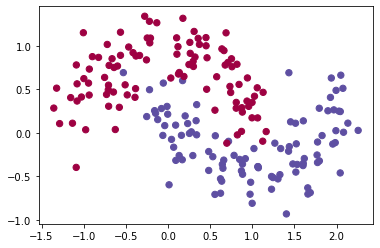

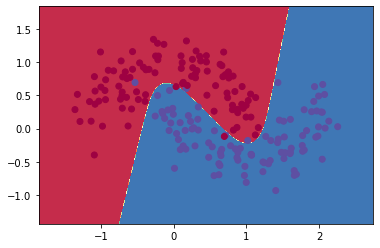

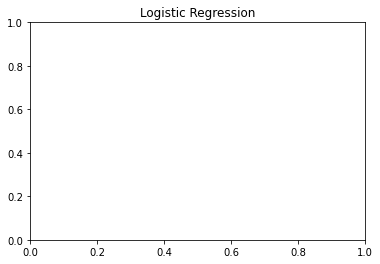

In [52]:
main()

### Test

In [4]:
X, y = make_classification(n_samples=3000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1,
                          class_sep=1,flip_y=0,weights=[0.5,0.5], random_state=945)
#y[y == 0] = -1

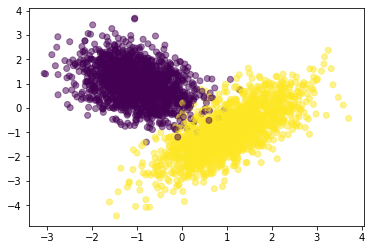

In [5]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### NNTest

In [7]:
nn = NNTest(hidden_layers = [10], max_iter=1000).fit(X_train, y_train)

NameError: name 'NNTest' is not defined

In [8]:
W, b, a, z, JW, Jb = nn.get_values()

NameError: name 'nn' is not defined

In [115]:
out = a[-1]
for i in range(len(out)):
    out[i][0] = round(out[i][0], 2)
for i in range(len(out)):
    print(str(out[i][0]).rjust(5), str(y_train[i]).rjust(5))

 0.99     1
  0.0     0
 0.99     1
  0.0     0
  0.0     0
 0.99     1
 0.99     1
 0.99     1
  0.0     0
 0.98     1
 0.99     1
 0.01     0
 0.99     1
 0.99     1
  0.0     0
 0.99     1
  0.0     0
 0.99     1
  1.0     1
 0.99     1
  1.0     1
 0.99     1
 0.05     0
  1.0     1
  0.0     0
 0.01     0
 0.01     0
 0.01     0
 0.98     1
 0.99     1
  1.0     1
  0.0     0
  1.0     1
 0.99     1
 0.99     1
 0.99     1
  1.0     1
 0.99     1
  0.0     0
  0.0     0
  0.0     0
  0.0     0
  1.0     1
  0.0     0
  1.0     1
  0.0     0
  1.0     1
 0.97     1
  0.0     0
  1.0     1
 0.99     1
  1.0     1
  1.0     1
  0.0     0
  0.0     0
  1.0     1
 0.99     1
 0.99     1
  0.0     0
  0.0     0
  0.0     0
  1.0     1
  0.0     0
 0.99     1
 0.99     1
 0.99     1
 0.01     0
  1.0     1
 0.98     1
 0.99     1
  0.0     0
 0.99     1
  0.0     0
 0.01     0
 0.99     1
 0.99     1
  0.0     0
  0.0     0
  0.0     0
  0.0     0
  0.0     0
 0.98     1
  0.0     0
  1.

 0.99     1
 0.98     1
  0.0     0
  0.0     0
 0.99     1
  0.0     0
 0.98     1
  0.0     0
 0.01     0
 0.99     1
  0.0     0
  0.0     0
  0.0     0
  0.0     0
 0.99     1
 0.99     1
  0.0     0
 0.99     1
 0.98     1
  1.0     1
  1.0     1
  1.0     1
 0.99     1
 0.99     1
  0.0     0
  0.0     0
 0.02     0
  0.0     0
 0.98     1
  0.0     0
  1.0     1
  0.0     0
 0.43     0
 0.01     0
  0.0     0
  0.0     0
 0.99     1
  0.0     0
 0.98     1
  1.0     1
  0.0     0
  0.0     0
 0.99     1
  0.0     0
 0.99     1
  0.0     0
  0.0     0
  0.0     0
  0.0     0
  0.0     0
  0.0     0
 0.99     1
  1.0     1
  0.0     0
 0.99     1
 0.99     1
  0.0     0
  0.0     0
  1.0     1
  1.0     1
  0.0     0
  1.0     1
  0.0     0
  0.0     0
  0.0     0
 0.01     0
  0.0     0
  0.0     0
  0.0     0
  0.0     0
  1.0     1
 0.99     1
 0.99     1
  0.0     0
  1.0     1
  0.0     0
 0.99     1
  0.0     0
 0.92     1
  0.1     0
 0.99     1
  1.0     1
  0.0     0
 0.9

In [520]:
nn.score(X_train, y_train)

0.9848888888888889

In [521]:
nn.score(X_test, y_test)

0.9933333333333333

34.24840972499716
562.356
[] score:  0.9390983474436173


<IPython.core.display.Javascript object>


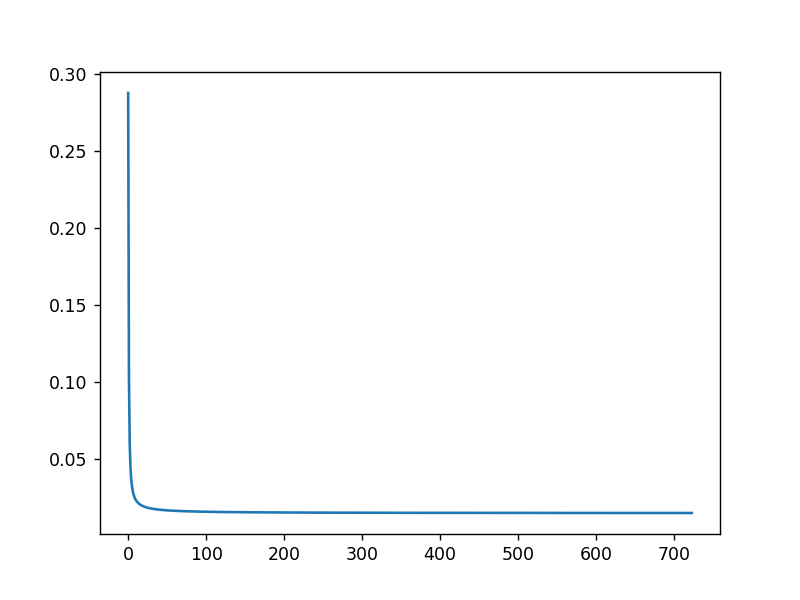

29.418846879117076
562.356
[10, 10] score:  0.947686435497946


<IPython.core.display.Javascript object>


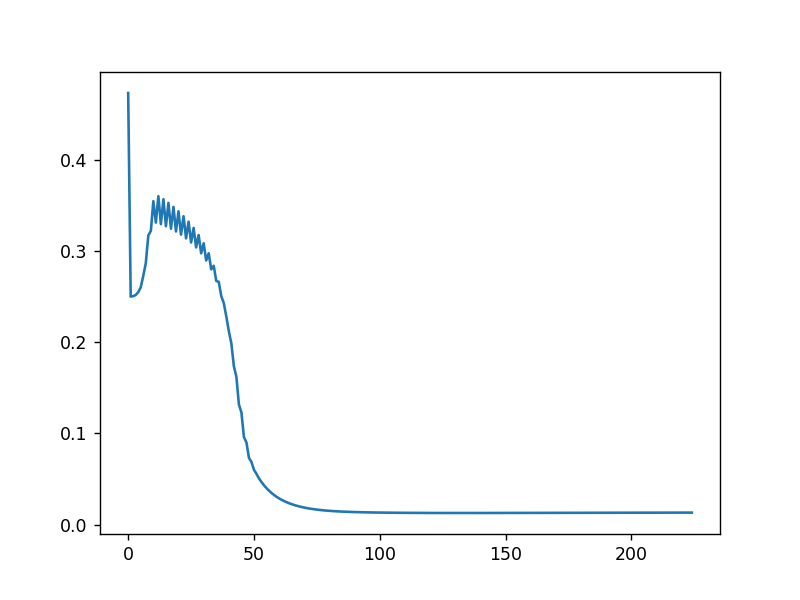

24.039253872433733
562.356
[50] score:  0.9572526053381955


<IPython.core.display.Javascript object>


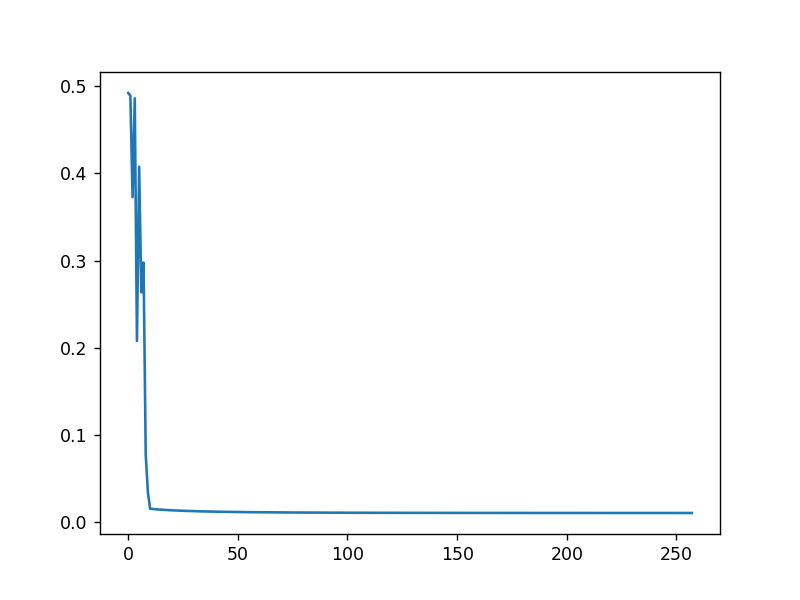

24.516161349311137
562.356
[100] score:  0.9564045527222771


<IPython.core.display.Javascript object>


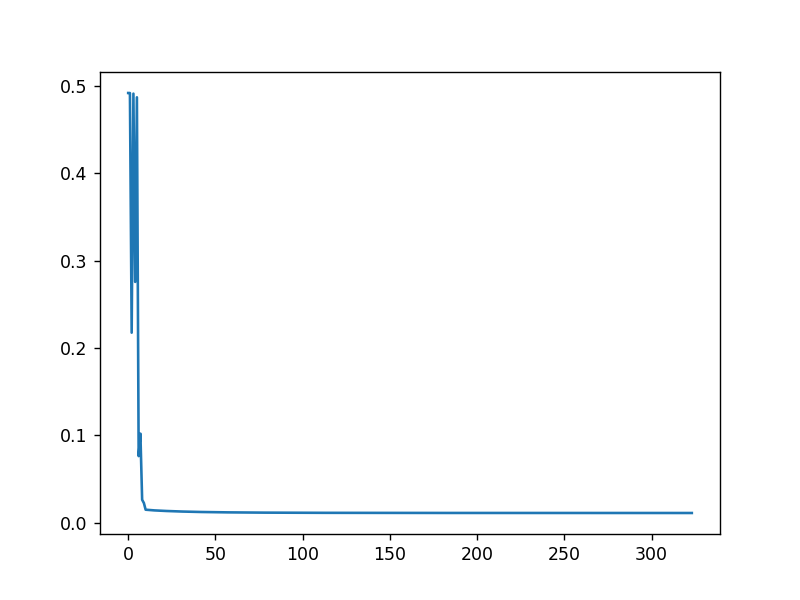

In [118]:
for h in [[], [10, 10], [50], [100]]:
    nn = NNTest(hidden_layers=h, max_iter=1000, learning_rate=0.001).fit(X_train, y_train)
    print(h, "score: ", nn.score(X_train, y_train))
    plt.figure()
    plt.plot(range(len(nn.costs)), nn.costs)

### NNClassifier

In [4]:
nn = NNClassifier().fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [21]:
W, b, a, z, JW, Jb = nn.get_values()

In [22]:
a[1]

array([[1.69125463e-02, 9.97735647e-01],
       [9.64715430e-01, 5.80171698e-02],
       [6.89226660e-03, 9.99443907e-01],
       ...,
       [9.80622984e-01, 2.45675009e-02],
       [9.60717026e-01, 6.37133396e-02],
       [3.61619721e-04, 9.99972230e-01]])

In [23]:
y_train

array([1, 0, 1, ..., 0, 0, 1])

In [24]:
nn.y

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [65]:
for i in a[1]:
    print(str(i[0].round(2)).rjust(5), str(i[1].round(2)).rjust(5))

  0.0   1.0
 0.98  0.02
  0.0   1.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
 0.88  0.12
  0.0   1.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
 0.99  0.01
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
 0.73  0.27
  0.0   1.0
  1.0   0.0
 0.95  0.05
 0.92  0.08
 0.88  0.12
 0.01  0.99
  0.0   1.0
  0.0   1.0
 0.96  0.04
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
 0.02  0.98
  1.0   0.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
 0.99  0.01
  1.0   0.0
  0.0   1.0
 0.99  0.01
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.9   0.1
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
 0.93  0.07
  0.0   1.0
 0.01  0.99
  1.0   0.0
 0.99  0.01
  1.0   0.0
  1.0   0.0
 0.98  0.02
  0.0   1.0
  1.0   0.0
  0.

  0.0   1.0
  1.0   0.0
  0.0   1.0
 0.02  0.98
 0.04  0.96
  1.0   0.0
 0.59  0.41
  0.0   1.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
 0.85  0.15
  1.0   0.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
 0.34  0.66
  0.0   1.0
 0.01  0.99
  1.0   0.0
 0.02  0.98
  0.0   1.0
 0.01  0.99
 0.99  0.01
 0.02  0.98
  1.0   0.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
 0.94  0.06
  0.0   1.0
 0.32  0.68
 0.26  0.74
  0.0   1.0
  0.9   0.1
  1.0   0.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
 0.02  0.98
  0.0   1.0
 0.97  0.03
  1.0   0.0
  1.0   0.0
  1.0   0.0
  1.0   0.0
 0.01  0.99
  0.5   0.5
  0.0   1.0
  1.0   0.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
 0.35  0.65
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
 0.99  0.01
 0.06  0.94
  1.0   0.0
  0.0   1.0
  0.0   1.0
 0.01  0.99
  1.0   0.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
 0.01  0.99
  0.0   1.0
 0.95  0.05
  1.0   0.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
 0.0

In [25]:
preds = nn.predict(X_test)

In [26]:
(preds.ravel() == y_test).sum() / len(y_test)

0.9826666666666667

In [27]:
nn.score(X_test, y_test)

0.9826666666666667

In [69]:
for i in nn.predict_proba(X_test):
    print(str(i[0].round(2)).rjust(5), str(i[1].round(2)).rjust(5))

  1.0   0.0
 0.98  0.02
  0.0   1.0
  0.0   1.0
  1.0   0.0
 0.11  0.89
  0.0   1.0
  0.0   1.0
  1.0   0.0
 0.01  0.99
  0.0   1.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
 0.98  0.02
  1.0   0.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
 0.95  0.05
  1.0   0.0
  0.0   1.0
  0.0   1.0
 0.33  0.67
  1.0   0.0
  0.0   1.0
 0.01  0.99
  0.0   1.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
 0.45  0.55
  0.0   1.0
  1.0   0.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  1.0   0.0
 0.08  0.92
 0.35  0.65
  1.0   0.0
  0.0   1.0
  1.0   0.0
  0.0   1.0
 0.99  0.01
  0.0   1.0
 0.99  0.01
  1.0   0.0
 0.91  0.09
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
  0.0   1.0
 0.17  0.83
  0.0   1.0
  0.0   1.0
 0.01  0.99
  0.0   1.0
 0.75  0.25
 0.02  0.98
 0.96  0.04
  1.0   0.0
  1.0   0.0
 0.72  0.28
  0.0   1.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  1.0   0.0
  1.0   0.0
  1.0   0.0
  0.0   1.0
  1.

#### test

In [5]:
X, y = make_classification(n_samples=3000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=3, n_clusters_per_class=1,
                          class_sep=2,flip_y=0,weights=[0.3,0.3,0.4], random_state=24)

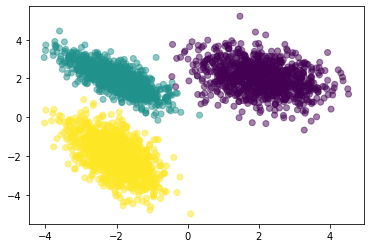

In [6]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
nn = NNClassifier(hidden_layers=[10, 10], max_iter=1000).fit(X_train, y_train)

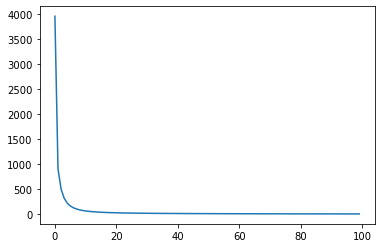

In [9]:
plt.figure()
plt.plot(range(len(nn.costs)), nn.costs)

In [10]:
nn.score(X_train, y_train)

0.9995555555555555

In [11]:
nn.score(X_test, y_test)

0.9973333333333333

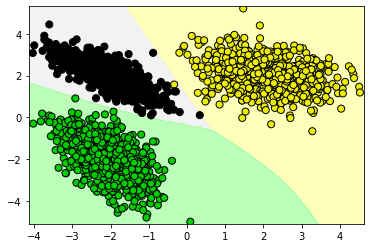

In [12]:
plot_classifier(nn, X_train, y_train)

### Mushroom test

In [13]:
mushrooms = pd.read_csv("datasets/mushrooms.csv")
data = pd.get_dummies(mushrooms)

In [14]:
data["edible"] = data["class_e"]
data.drop(["class_e", "class_p"], inplace=True, axis=1)
target_names=["Poisoned", "Edible"]

In [15]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [18]:
#pca
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_2d, y, random_state=0)

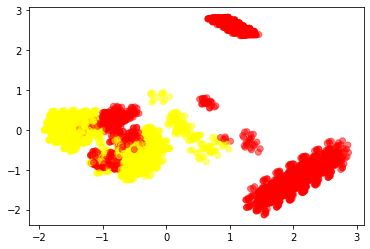

In [20]:
# vis
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="autumn", marker="o", alpha=0.5)

In [21]:
#neural network
nn = NNClassifier(hidden_layers=[20, 20], max_iter=1000, learning_rate=0.001).fit(X_train, y_train)

In [22]:
nn.score(X_test, y_test)

0.9497784342688331

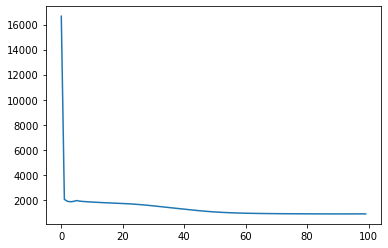

In [23]:
plt.figure()
plt.plot(range(len(nn.costs)), nn.costs)

In [24]:
nn.predict(np.array([[2, -1]]))

array([0], dtype=uint8)

In [25]:
nn.predict(np.array([[0, 0]]))

array([1], dtype=uint8)

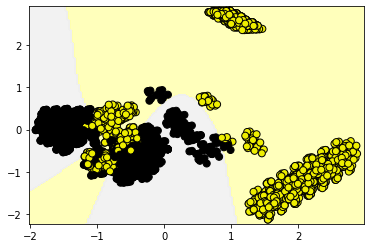

In [26]:
plot_classifier(nn, X_train, y_train)

### saving and loading model

### nonlinear dataset test

In [4]:
X, y = datasets.make_moons(200, noise=0.2)

In [5]:
X

array([[ 1.82486860e+00,  1.12450597e-01],
       [-2.27298618e-02,  4.71707065e-01],
       [-7.93037843e-02,  5.69014575e-01],
       [-1.72531260e-01, -4.70573745e-01],
       [ 9.95820843e-02,  3.85241377e-02],
       [ 7.18628700e-01, -3.21939859e-01],
       [ 6.60468602e-01, -2.47897192e-01],
       [-1.11334436e+00,  4.01662526e-01],
       [ 1.41050389e+00, -3.05294744e-01],
       [ 8.37939986e-01, -1.99927664e-01],
       [ 6.98922627e-01,  7.89808919e-01],
       [-2.64005166e-02,  5.49976762e-01],
       [-2.50083755e-01,  6.55395682e-01],
       [ 2.09459867e-01,  3.80886317e-01],
       [ 1.36939587e+00,  7.40867156e-02],
       [ 1.12345714e+00,  6.58991056e-01],
       [ 1.01594113e+00,  4.18402870e-01],
       [ 3.56655582e-01,  1.06398438e+00],
       [ 4.09346139e-02, -6.22885375e-02],
       [ 6.17057062e-01, -1.44949353e-02],
       [ 1.52019501e-01,  1.51198010e+00],
       [ 1.45568425e+00, -1.83550306e-02],
       [ 2.46259683e-01,  1.00593017e+00],
       [ 1.

In [8]:
y

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1], dtype=int64)

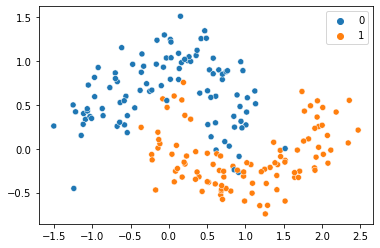

In [9]:
plt.figure()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [10]:
nn = NNClassifier(hidden_layers=[10, 10], max_iter=5000, learning_rate=0.001).fit(X, y)

In [11]:
nn.costs[-1]

15.728113916581531

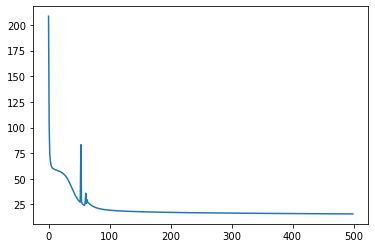

In [12]:
plt.figure()
plt.plot(range(len(nn.costs)), nn.costs)

In [13]:
nn.score(X, y)

0.98

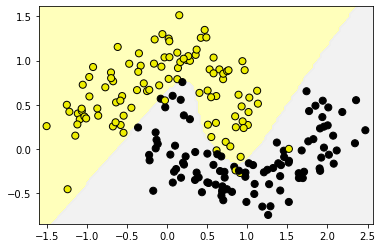

In [14]:
plot_classifier(nn, X, y)

In [18]:
#save
#nn.save("moon")

In [19]:
#load
nn = NNClassifier().load("moon")

In [20]:
nn.score(X, y)

0.98

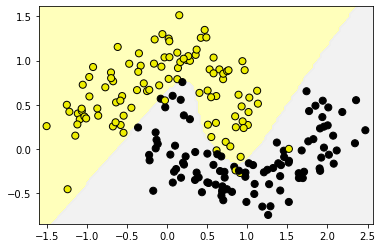

In [21]:
plot_classifier(nn, X, y)